# Train a VAE on Cell Painting LINCS Data

In [1]:
import sys
import pathlib
import numpy as np
import pandas as pd
sys.path.insert(0, "../../scripts")
from utils import load_data


from pycytominer.cyto_utils import infer_cp_features


import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

from sklearn.decomposition import PCA
from tensorflow import keras

from vae import VAE

from tensorflow.keras.models import Model, Sequential
import seaborn
import random as python_random
import tensorflow as tf


In [4]:
def remove_moa(df):
    pipes = ['cytochrome P450 inhibitor|protein synthesis inhibitor',
            'thromboxane receptor antagonist|thromboxane synthase inhibitor',
            'serotonin receptor antagonist|sodium channel blocker',
            'antiviral|RNA synthesis inhibitor',
            'adenosine receptor antagonist|phosphodiesterase inhibitor']    
    moas =  []
    for pipe in pipes:
        moas.append(pipe)
        moas.append(pipe.split('|')[0])
        moas.append(pipe.split('|')[1])
    return df[~df.moa.isin(moas)]

In [5]:
data_splits = ["train", "test", "valid","complete"]
data_dict = load_data(data_splits)

/home/ubuntu/miniconda3/envs/cell-painting-vae/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3361: DtypeWarning: Columns (18,19) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


In [6]:
# Prepare data for training
meta_features = infer_cp_features(data_dict["train"], metadata=True)
cp_features = infer_cp_features(data_dict["train"])

moa_df_train = pd.read_csv("../3.application/repurposing_info_external_moa_map_resolved.tsv",sep='\t').set_index('broad_sample').reindex(index=data_dict['train']['Metadata_broad_sample']).reset_index().drop('Metadata_broad_sample',axis = 1)
data_dict['train'] = pd.concat([moa_df_train,data_dict['train']], axis=1)

moa_df_valid = pd.read_csv("../3.application/repurposing_info_external_moa_map_resolved.tsv",sep='\t').set_index('broad_sample').reindex(index=data_dict['valid']['Metadata_broad_sample']).reset_index().drop('Metadata_broad_sample',axis = 1)
data_dict['valid'] = pd.concat([moa_df_valid,data_dict['valid']], axis=1)

data_dict['train'] = remove_moa(data_dict['train'])
data_dict['valid'] = remove_moa(data_dict['valid'])

train_features_df = data_dict["train"].reindex(cp_features, axis="columns")
train_meta_df = data_dict["train"].reindex(meta_features, axis="columns")

test_features_df = data_dict["test"].reindex(cp_features, axis="columns")
test_meta_df = data_dict["test"].reindex(meta_features, axis="columns")

valid_features_df = data_dict["valid"].reindex(cp_features, axis="columns")
valid_meta_df = data_dict["valid"].reindex(meta_features, axis="columns")

complete_features_df = data_dict["complete"].reindex(cp_features, axis="columns")
complete_meta_df = data_dict["complete"].reindex(meta_features, axis="columns")


In [7]:
print(train_features_df.shape)
train_features_df.head(3)

(38170, 685)


,Cells_AreaShape_Compactness,Cells_AreaShape_Eccentricity,Cells_AreaShape_Extent,Cells_AreaShape_FormFactor,Cells_AreaShape_MedianRadius,Cells_AreaShape_Orientation,Cells_AreaShape_Solidity,Cells_AreaShape_Zernike_0_0,Cells_AreaShape_Zernike_1_1,Cells_AreaShape_Zernike_2_0,...,Nuclei_Texture_SumEntropy_DNA_5_0,Nuclei_Texture_SumEntropy_Mito_5_0,Nuclei_Texture_SumEntropy_RNA_20_0,Nuclei_Texture_SumEntropy_RNA_5_0,Nuclei_Texture_SumVariance_DNA_20_0,Nuclei_Texture_SumVariance_RNA_20_0,Nuclei_Texture_Variance_DNA_20_0,Nuclei_Texture_Variance_ER_20_0,Nuclei_Texture_Variance_RNA_10_0,Nuclei_Texture_Variance_RNA_20_0
1,0.18605,0.68873,0.41051,0.31982,0.19885,0.72510,0.39552,0.38362,0.65094,0.89679,...,0.61393,0.38269,0.63814,0.68204,0.23700,0.32808,0.27981,0.26893,0.34938,0.33179
2,0.19083,0.66276,0.38585,0.31437,0.20415,0.71380,0.38701,0.36699,0.60932,0.88492,...,0.60850,0.41850,0.63529,0.65208,0.22852,0.32710,0.29371,0.27159,0.33871,0.31965
3,0.17934,0.67469,0.38835,0.31453,0.20468,0.72474,0.39699,0.37328,0.64139,0.89582,...,0.60439,0.38586,0.65320,0.66223,0.22899,0.31620,0.29548,0.26682,0.35609,0.34152


In [8]:
print(test_features_df.shape)
test_features_df.head(3)

(5030, 685)


,Cells_AreaShape_Compactness,Cells_AreaShape_Eccentricity,Cells_AreaShape_Extent,Cells_AreaShape_FormFactor,Cells_AreaShape_MedianRadius,Cells_AreaShape_Orientation,Cells_AreaShape_Solidity,Cells_AreaShape_Zernike_0_0,Cells_AreaShape_Zernike_1_1,Cells_AreaShape_Zernike_2_0,...,Nuclei_Texture_SumEntropy_DNA_5_0,Nuclei_Texture_SumEntropy_Mito_5_0,Nuclei_Texture_SumEntropy_RNA_20_0,Nuclei_Texture_SumEntropy_RNA_5_0,Nuclei_Texture_SumVariance_DNA_20_0,Nuclei_Texture_SumVariance_RNA_20_0,Nuclei_Texture_Variance_DNA_20_0,Nuclei_Texture_Variance_ER_20_0,Nuclei_Texture_Variance_RNA_10_0,Nuclei_Texture_Variance_RNA_20_0
0,0.19050,0.68937,0.39383,0.33072,0.20185,0.72292,0.38085,0.37504,0.61905,0.88361,...,0.60356,0.39345,0.63470,0.63406,0.23588,0.36061,0.30092,0.23638,0.36015,0.32779
1,0.18661,0.67731,0.39621,0.32318,0.20716,0.70964,0.39401,0.37779,0.60275,0.88912,...,0.60936,0.40380,0.64406,0.64859,0.22752,0.29811,0.29430,0.25475,0.34154,0.32013
2,0.18626,0.67036,0.41101,0.31863,0.20182,0.71139,0.40302,0.38979,0.59188,0.86857,...,0.61009,0.40904,0.64250,0.63285,0.23931,0.33179,0.28571,0.24980,0.34516,0.32968


In [9]:
print(complete_features_df.shape)
complete_features_df.head(3)

(50303, 685)


,Cells_AreaShape_Compactness,Cells_AreaShape_Eccentricity,Cells_AreaShape_Extent,Cells_AreaShape_FormFactor,Cells_AreaShape_MedianRadius,Cells_AreaShape_Orientation,Cells_AreaShape_Solidity,Cells_AreaShape_Zernike_0_0,Cells_AreaShape_Zernike_1_1,Cells_AreaShape_Zernike_2_0,...,Nuclei_Texture_SumEntropy_DNA_5_0,Nuclei_Texture_SumEntropy_Mito_5_0,Nuclei_Texture_SumEntropy_RNA_20_0,Nuclei_Texture_SumEntropy_RNA_5_0,Nuclei_Texture_SumVariance_DNA_20_0,Nuclei_Texture_SumVariance_RNA_20_0,Nuclei_Texture_Variance_DNA_20_0,Nuclei_Texture_Variance_ER_20_0,Nuclei_Texture_Variance_RNA_10_0,Nuclei_Texture_Variance_RNA_20_0
0,0.19575,0.67566,0.40288,0.32633,0.20267,0.71477,0.39122,0.38048,0.61184,0.88375,...,0.60865,0.38869,0.65364,0.65716,0.24912,0.33129,0.28864,0.27106,0.35254,0.32675
1,0.18472,0.66556,0.39721,0.30968,0.20009,0.71345,0.39953,0.37314,0.61074,0.87695,...,0.60682,0.39779,0.64013,0.63120,0.24380,0.30471,0.28554,0.27852,0.35157,0.31637
2,0.18254,0.69650,0.39596,0.33502,0.20420,0.72770,0.39590,0.37023,0.60264,0.88038,...,0.60665,0.39705,0.66616,0.62889,0.25125,0.33549,0.29656,0.25706,0.33868,0.31901


In [10]:
# VAE of one layer

encoder_architecture = [250]
decoder_architecture = [250]



In [11]:
cp_vae = VAE(
    input_dim=train_features_df.shape[1],
    latent_dim=90,
    batch_size=32,
    encoder_batch_norm=True,
    epochs=58,
    learning_rate=0.0001,
    encoder_architecture=encoder_architecture,
    decoder_architecture=decoder_architecture,
    beta=0.06,
    verbose=True,
)

cp_vae.compile_vae()

In [12]:
cp_vae.train(x_train=train_features_df, x_test=valid_features_df)

Epoch 1/58
1193/1193 [==============================] - 24s 14ms/step - loss: 122.0518 - recon: 57.4903 - kl: 0.8025 - mmd: 0.0000e+00 - val_loss: 13.1307 - val_recon: 12.2870 - val_kl: 0.8437 - val_mmd: 0.0000e+00
Epoch 2/58
1193/1193 [==============================] - 15s 13ms/step - loss: 9.9690 - recon: 7.7723 - kl: 0.5619 - mmd: 0.0000e+00 - val_loss: 6.1224 - val_recon: 5.5543 - val_kl: 0.5681 - val_mmd: 0.0000e+00
Epoch 3/58
1193/1193 [==============================] - 15s 13ms/step - loss: 5.5351 - recon: 4.6046 - kl: 0.4446 - mmd: 0.0000e+00 - val_loss: 4.1262 - val_recon: 3.7050 - val_kl: 0.4212 - val_mmd: 0.0000e+00
Epoch 4/58
1193/1193 [==============================] - 15s 13ms/step - loss: 3.8641 - recon: 3.1947 - kl: 0.3671 - mmd: 0.0000e+00 - val_loss: 3.1317 - val_recon: 2.7148 - val_kl: 0.4168 - val_mmd: 0.0000e+00
Epoch 5/58
1193/1193 [==============================] - 15s 13ms/step - loss: 2.7834 - recon: 2.2949 - kl: 0.2974 - mmd: 0.0000e+00 - val_loss: 2.3166 - va

Epoch 40/58
1193/1193 [==============================] - 16s 13ms/step - loss: 0.7782 - recon: 0.7039 - kl: 0.0875 - mmd: 0.0000e+00 - val_loss: 0.8067 - val_recon: 0.6524 - val_kl: 0.1542 - val_mmd: 0.0000e+00
Epoch 41/58
1193/1193 [==============================] - 21s 18ms/step - loss: 0.8114 - recon: 0.7011 - kl: 0.0875 - mmd: 0.0000e+00 - val_loss: 0.7506 - val_recon: 0.6414 - val_kl: 0.1091 - val_mmd: 0.0000e+00
Epoch 42/58
1193/1193 [==============================] - 26s 22ms/step - loss: 0.7806 - recon: 0.6999 - kl: 0.0869 - mmd: 0.0000e+00 - val_loss: 0.7728 - val_recon: 0.6575 - val_kl: 0.1153 - val_mmd: 0.0000e+00
Epoch 43/58
1193/1193 [==============================] - 18s 15ms/step - loss: 0.7794 - recon: 0.6963 - kl: 0.0875 - mmd: 0.0000e+00 - val_loss: 0.7716 - val_recon: 0.6526 - val_kl: 0.1190 - val_mmd: 0.0000e+00
Epoch 44/58
1193/1193 [==============================] - 16s 14ms/step - loss: 0.7960 - recon: 0.6974 - kl: 0.0867 - mmd: 0.0000e+00 - val_loss: 0.8057 - va

In [13]:
cp_vae.vae

In [14]:
# Save training performance
history_df = pd.DataFrame(cp_vae.vae.history.history)
history_df

,loss,recon,kl,mmd,val_loss,val_recon,val_kl,val_mmd
0,58.292843,57.490314,0.802487,0.0,13.130677,12.287017,0.843660,0.0
1,8.334225,7.772343,0.561887,0.0,6.122387,5.554319,0.568067,0.0
2,5.049180,4.604609,0.444574,0.0,4.126220,3.705049,0.421171,0.0
3,3.561778,3.194679,0.367099,0.0,3.131655,2.714819,0.416835,0.0
4,2.592312,2.294902,0.297410,0.0,2.316570,1.977379,0.339189,0.0
5,1.962671,1.730283,0.232389,0.0,1.758110,1.495534,0.262575,0.0
6,1.569218,1.386809,0.182410,0.0,1.407089,1.200291,0.206797,0.0
7,1.324177,1.178900,0.145277,0.0,1.270231,1.072258,0.197974,0.0
8,1.170606,1.048365,0.122242,0.0,1.187065,0.968830,0.218234,0.0
9,1.070993,0.965696,0.105298,0.0,0.991869,0.869011,0.122858,0.0


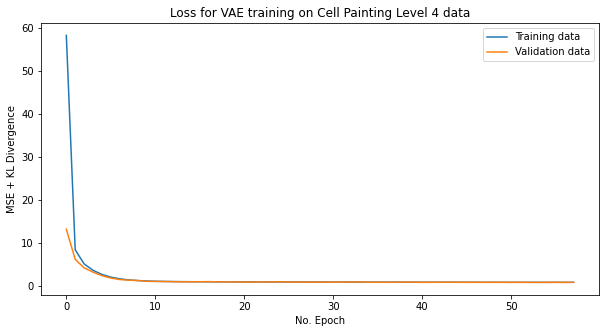

In [17]:
plt.figure(figsize=(10, 5))
plt.plot(history_df["loss"], label="Training data")
plt.plot(history_df["val_loss"], label="Validation data")
plt.title("Loss for VAE training on Cell Painting Level 4 data")
plt.ylabel("MSE + KL Divergence")
plt.xlabel("No. Epoch")
plt.legend()
plt.show()

In [18]:
cp_vae.vae.evaluate(test_features_df)

158/158 [==============================] - 1s 6ms/step - loss: 0.7348 - recon: 0.6182 - kl: 0.1166 - mmd: 0.0000e+00


[0.7348112463951111, 0.6181932687759399, 0.1166178360581398, 0.0]

In [19]:
reconstruction = pd.DataFrame(cp_vae.vae.predict(test_features_df), columns=cp_features)
(sum(sum((np.array(test_features_df) - np.array(reconstruction)) ** 2))) ** 0.5

55.54928503745787

<AxesSubplot:>

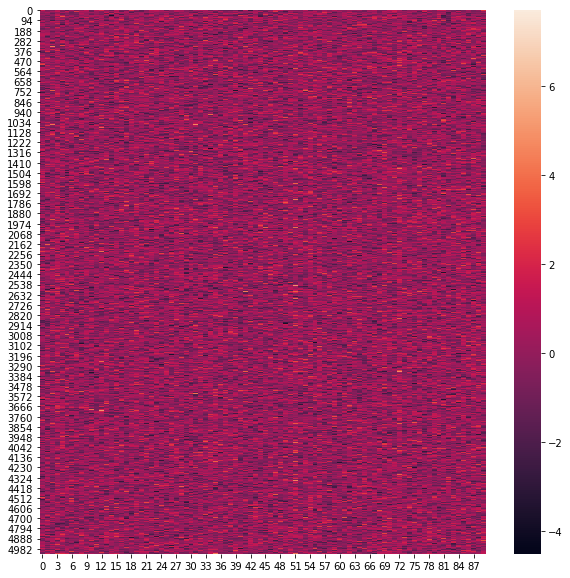

In [20]:
#latent space heatmap
fig, ax = plt.subplots(figsize=(10, 10))
encoder = cp_vae.encoder_block["encoder"]
latent = np.array(encoder.predict(test_features_df)[2])
seaborn.heatmap(latent, ax=ax)

In [21]:
reconstruction = pd.DataFrame(cp_vae.vae.predict(test_features_df), columns=cp_features)
pca = PCA(n_components=2).fit(test_features_df)
pca_reconstructed_latent_df = pd.DataFrame(pca.transform(reconstruction))
pca_test_latent_df = pd.DataFrame(pca.transform(test_features_df))


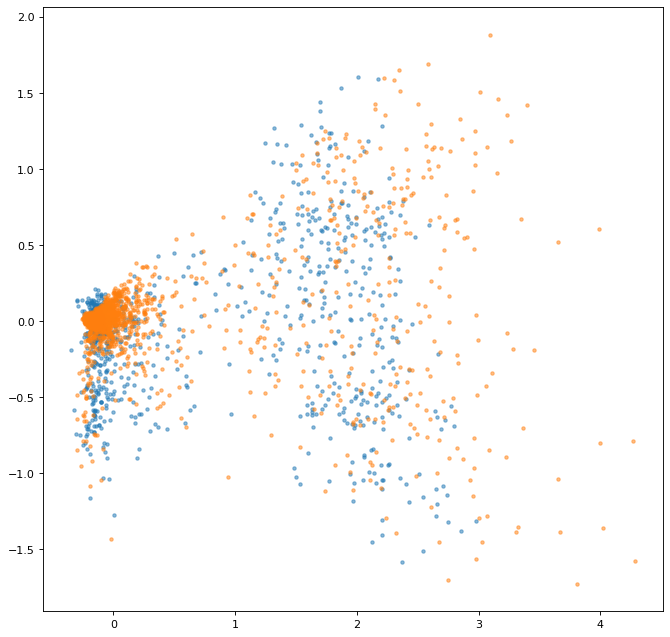

In [22]:
figure(figsize=(10, 10), dpi=80)
plt.scatter(pca_test_latent_df[0],pca_test_latent_df[1], marker = ".", alpha = 0.5)
plt.scatter(pca_reconstructed_latent_df[0],pca_reconstructed_latent_df[1], marker = ".", alpha = 0.5)

In [25]:
decoder = cp_vae.decoder_block["decoder"]

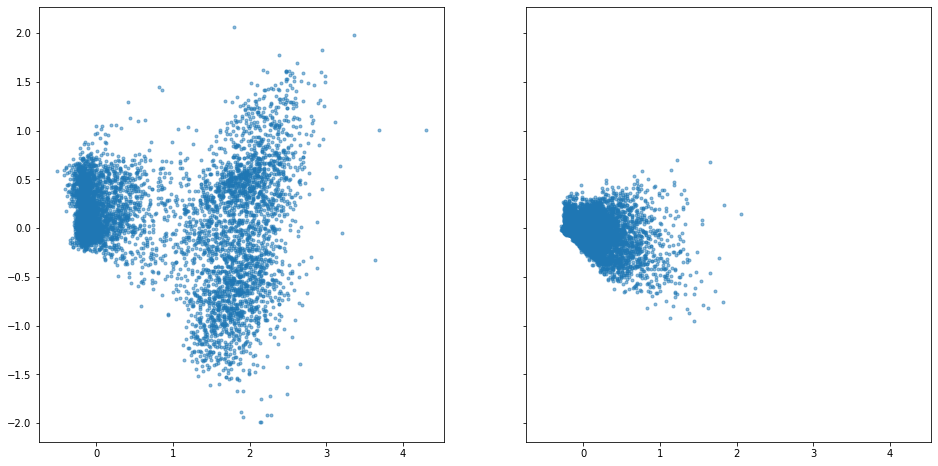

In [26]:
pca_training = PCA(n_components=2).fit(train_features_df)

simulated_df = pd.DataFrame(np.random.normal(size=(40242, 90)), columns=np.arange(0,90))
reconstruction_of_simulated = decoder.predict(simulated_df)
pca_reconstruction_of_simulated = pd.DataFrame(pca_training.transform(reconstruction_of_simulated))
pca_train_latent_df = pd.DataFrame(pca_training.transform(train_features_df))

fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(16,8), sharey = True, sharex = True)
ax1.scatter(pca_train_latent_df[0],pca_train_latent_df[1], marker = ".", alpha = 0.5)
ax2.scatter(pca_reconstruction_of_simulated[0],pca_reconstruction_of_simulated[1], marker = ".", alpha = 0.5)

In [27]:
from scipy.spatial.distance import directed_hausdorff
max(directed_hausdorff(reconstruction_of_simulated, train_features_df)[0],directed_hausdorff(train_features_df,reconstruction_of_simulated)[0])

8.706190140019404

In [28]:
#NOTE: IF YOU RUN THIS, YOU WILL NOT BE ABLE TO REPRODUCE THE EXACT RESULTS IN THE EXPERIMENT
latent_complete = np.array(encoder.predict(complete_features_df)[2])
latent_df = pd.DataFrame(latent_complete)
latent_df.to_csv("../3.application/level4Latent_leaveOut.csv")

In [29]:
#NOTE: IF YOU RUN THIS, YOU WILL NOT BE ABLE TO REPRODUCE THE EXACT RESULTS IN THE EXPERIMENT
decoder.save("models/level4Decoder_leaveOut")

INFO:tensorflow:Assets written to: level4Decoder_leaveOut/assets


In [30]:
encoder.save("models/level4Encoder_leaveOut")

INFO:tensorflow:Assets written to: level4Encoder_leaveOut/assets
